# Laplacian Out of the Money Price Simulation



In [1]:

import math
import random as random

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


# Fee calculator
def bsm_no_premium_call_option_fee(S0, T, sigma):
    # BSM no-premium option strike calculator
    def bsm_no_premium_strike(S0, T, sigma):
        # init
        r = 0.0
        K_at_money = S0
        # bsm terms
        d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
        d2 = d1 - sigma * sqrt(T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        def bsm_premium(K):
            # bsm premium
            BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
            return BSM_C0_no_premium
        
        K_no_premium = fsolve(bsm_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = bsm_no_premium_strike(S0, T, sigma)

    fee = (K_no_premium-S0)/S0

    return fee

def mc_no_premium_call_option_fee(S0, T, sigma, I):
    # MC no-premium option strike calculator
    def mc_no_premium_strike(S0, T, sigma, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng()
        ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * mc_rng.standard_normal(I))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_no_premium_strike(S0, T, sigma, I)

    fee = (K_no_premium-S0)/S0

    return fee

# Data set
btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

vol_2min = btcusd_1min['ret_2min'].std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Monte Carlo Simulation

It has already been established in [Log Normal At the Money Price Simulation](normal_at_money_simulation.ipynb) and [Log Normal Out of the Money Price Simulation](normal_out_money_simulation.ipynb) that a Monte Carlo simulation with normally distributed samples estimates the same option premium as the Black–Scholes–Merton analytical formula.

It is also apparent from [Historical Returns Distribution fitting](historical_returns_fit.ipynb) that the BTC/USD returns are not normally distributed and that a Laplace distribution might be more representative of the observed fat tails.

A Monte Carlo simulation using Laplacian samples will be implemented to compare the impact on the "no-premium" option's stike.



In [3]:

# underlying price at t=0
S0 = 30_000.00

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# calc bsm fee
bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)

# calc mc fee
mc_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|BSM fee|{float('%.5g' % (bsm_fee*100))}%|\n"
table2 += f"|MC fee|{float('%.5g' % (mc_fee*100))}%|\n"

md(f"""### Simulation calculated variables
{header}
{table}
### Calculated Fees
{header}
{table2}
""")


### Simulation calculated variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|I|1000000|

### Calculated Fees
|variable|value|
|:-:|-:|
|BSM fee|0.23448%|
|MC fee|0.23447%|



In [6]:

# Using the most recent 30 days worth of data only
# nb_2min_in_30d = 30*24*60/2 # = 21600
# ret_2min = btcusd_1min['ret_2min'][-21600:]
ret_2min = btcusd_1min['ret_2min'][2:]

# override the 2-min vol
vol_2min = ret_2min.std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)

mean = ret_2min.mean()
std = ret_2min.std()

# Fit the Laplace PDF.
loc,scale = laplace.fit(ret_2min)


In [7]:

# Calculate the fee
fee = bsm_no_premium_call_option_fee(S0, T, sigma)
K_no_premium = S0*(1+fee)

# number of price simulations
I = 1_000_000

# fixes the seed for reproducibility
rng = default_rng(99)
# rng = default_rng()

# underlying price vector from lplacian 2-minute log-returns
ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

# underlying price vector from lplacian 2-minute log-returns
ST_actual = S0 * np.exp(ret_2min)

# # underlying price vector from lplacian 2-minute log-returns
# ret_2min_boot = random.choices(ret_2min, k=ret_2min.size)
# ST_boot = S0 * np.exp(ret_2min_boot)


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|fee|{float('%.5g' % (fee*100))}%|\n"
table += f"|K_no_premium|{float('%.7g' % K_no_premium)} USD|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|S(T)|{ST[:5].round(1)}...|\n"

table3 = ""
table3 += f"|S(T) loc|{float('%.7g' % loc)}|\n"
table3 += f"|S(T) scale|{float('%.4g' % scale)}|\n"

md(f"""### Simulation calculated variables
{header}
{table}
### Terminal prices samples
{header}
{table2}
### Terminal prices stats
{header}
{table3}
""")


### Simulation calculated variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|fee|0.23448%|
|K_no_premium|30070.34 USD|
|I|1000000|

### Terminal prices samples
|variable|value|
|:-:|-:|
|S(T)|[30017.3 29999.  30043.  29887.3 30039.1]...|

### Terminal prices stats
|variable|value|
|:-:|-:|
|S(T) loc|0.0|
|S(T) scale|0.001361|



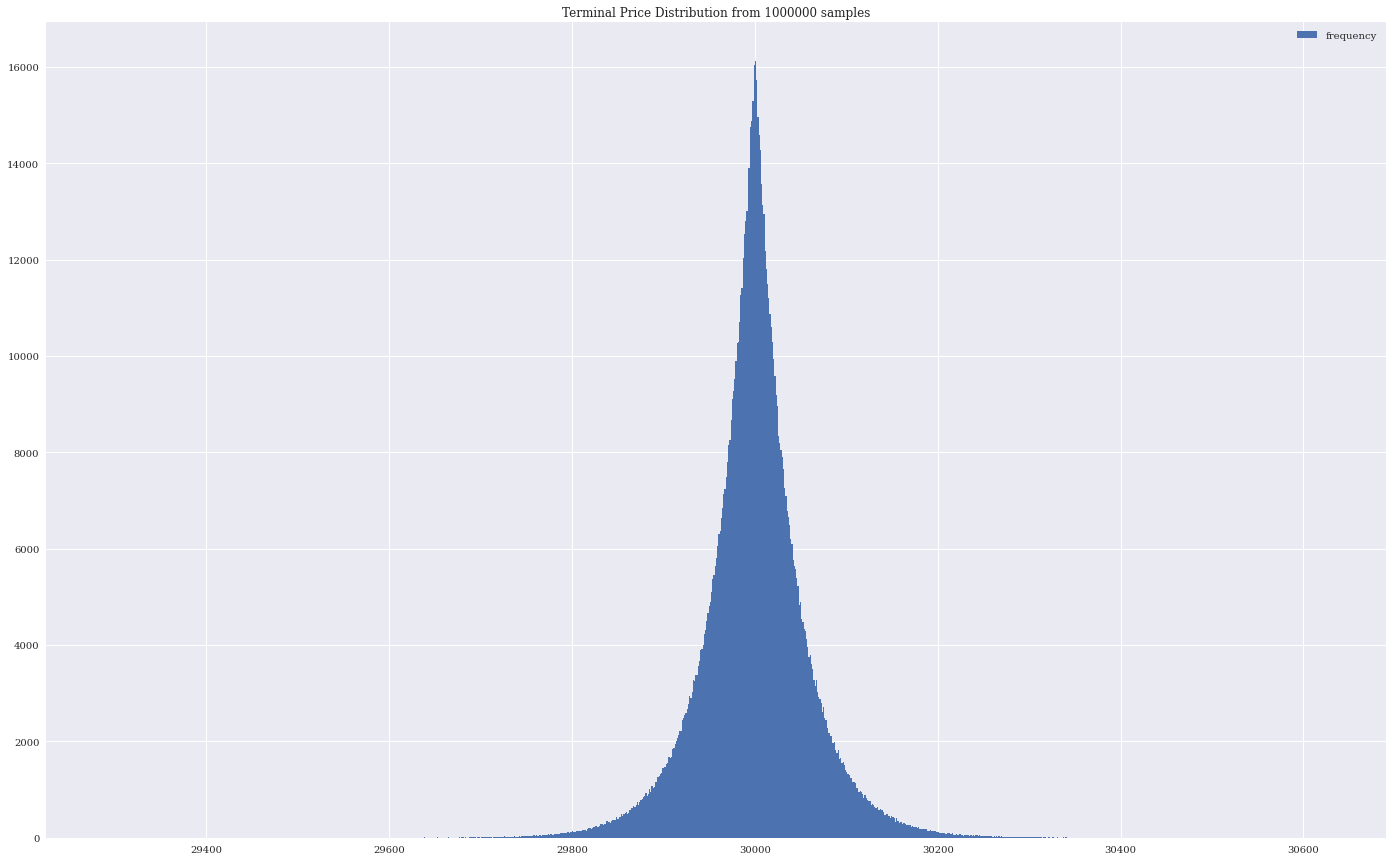

In [8]:

plt.figure(figsize=(24, 15))
plt.hist(ST, bins=1000, label='frequency');

# plt.axvline(ST_mean, color='r', label=f"mean ({float('%.7g' % (ST_mean))})")

# plt.axvline(ST_mean + 1 * ST_std, color='g',      label=f"+1 sd ({float('%.7g' % (ST_mean + 1 * ST_std))})", linestyle='--')
# plt.axvline(ST_mean - 1 * ST_std, color='g',      label=f"-1 sd ({float('%.7g' % (ST_mean - 1 * ST_std))})", linestyle='--')

# plt.axvline(ST_mean + 2 * ST_std, color='b',      label=f"+2 sd ({float('%.7g' % (ST_mean + 2 * ST_std))})", linestyle='--')
# plt.axvline(ST_mean - 2 * ST_std, color='b',      label=f"-2 sd ({float('%.7g' % (ST_mean - 2 * ST_std))})", linestyle='--')

# plt.axvline(ST_mean + 3 * ST_std, color='m',      label=f"+3 sd ({float('%.7g' % (ST_mean + 3 * ST_std))})", linestyle='--')
# plt.axvline(ST_mean - 3 * ST_std, color='m',      label=f"-3 sd ({float('%.7g' % (ST_mean - 3 * ST_std))})", linestyle='--')

# plt.axvline(ST_mean + 4 * ST_std, color='k',      label=f"+4 sd ({float('%.7g' % (ST_mean + 4 * ST_std))})", linestyle='--')
# plt.axvline(ST_mean - 4 * ST_std, color='k',      label=f"-4 sd ({float('%.7g' % (ST_mean - 4 * ST_std))})", linestyle='--')

# plt.axvline(ST_mean + 5 * ST_std, color='orange', label=f"+5 sd ({float('%.7g' % (ST_mean + 5 * ST_std))})", linestyle='--')
# plt.axvline(ST_mean - 5 * ST_std, color='orange', label=f"-5 sd ({float('%.7g' % (ST_mean - 5 * ST_std))})", linestyle='--')

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()